# This is a short notebook where we define and run an algorithm simulating the invasion of a population of species X by a population of species Y.

## First, we import the required libraries

In [6]:
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from copy import deepcopy
import glob
import pandas as pd
from matplotlib.lines import Line2D


## Then we define the "invasion" function

In [7]:
def invasion_thermo(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation=False):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir('output'):
        path = os.path.join('output', f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        resY = open(f"output/Time_{r + 1}.dat", "w")
        resSp = open(f"output/Stoichio_{r + 1}.dat", "w")
        resY.truncate(0)
        resSp.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
            
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        def dydt(t, Y):
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10:
                        prod_term = 1e10
                    rater[l] *= prod_term
                
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
                kd = 0.01*[random.uniform(0.95, 1.05) for _ in range(N_Y)]
                degradation_term = np.array(kd) * Y
                # Ensure no negative or zero values
                degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
                curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)

        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        # Write the full time series of Y_tot
        for t, y in zip(sol.t, sol.y.sum(axis=0)):
            resY.write(f"{t:.3f} {y:.3f}\n")
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            survival.append(False)

        resSp.close()
        resY.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival


## Now, we define parameters and run the code itself

In [8]:
# Define parameters
ttot = 200.0  # Total simulation time
dt = 1.0E-3  # Timestep
REALIZATIONS = 5  # Number of simulation runs
N_X = 3  # Number of original species
N_Y = 3  # Number of invaders
N_RY = 3  # Number of reactions for invaders

In [9]:
# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival = invasion_thermo(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted = True, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

4/5 Realizations led to successful invasion


## Finally, we plot all the time series

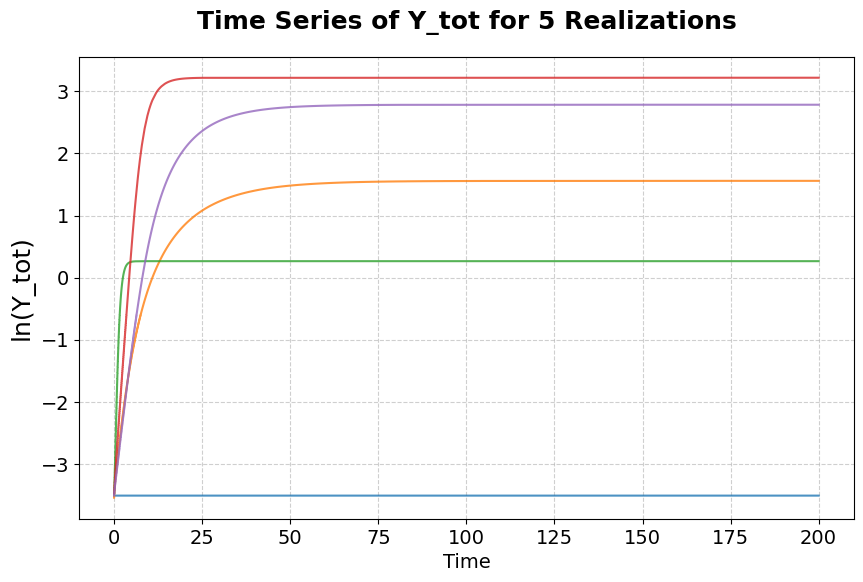

In [10]:
# Specify the output folder
folder_path = "output"

# Find and sort the "Time_X.dat" files
file_list = glob.glob(f"{folder_path}/Time_*.dat")
file_list.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort by realization number

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each file and plot its time series
for file in file_list:
    # Read the data
    data = pd.read_csv(file, delimiter=' ', header=None, names=['Time', 'Y_tot'])
    
    # Plot each realization
    plt.plot(data['Time'], np.log(data['Y_tot']), linewidth=1.5, alpha=0.8)

# Add title and labels
plt.title(f'Time Series of Y_tot for {len(file_list)} Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Y_tot)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

